# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 12.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
X_1, y_1 = datasets.make_classification(n_samples=500, n_features=2, n_redundant=0, n_clusters_per_class=1, flip_y=0, class_sep=5, random_state=30)

In [33]:
figure = plt.rcParams["figure.figsize"]
figure[0] = 20
figure[1] = 13
plt.show()

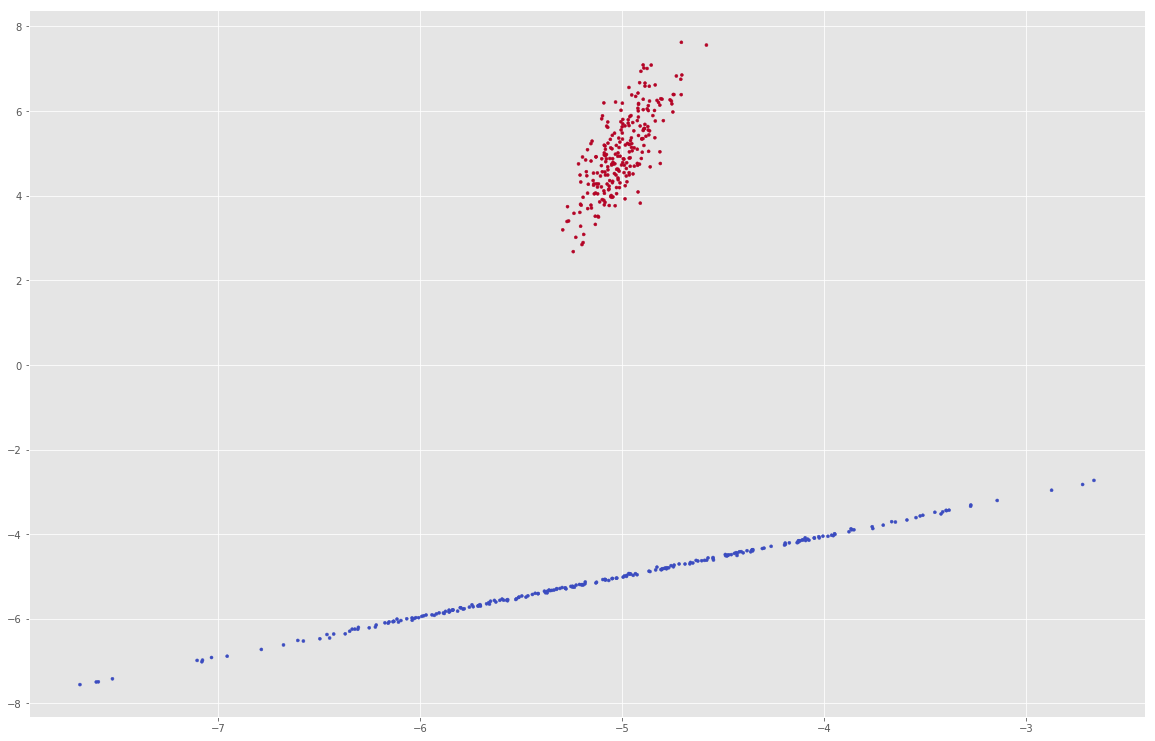

In [34]:
plt.scatter(X_1[:, 0], X_1[:, 1], c = y_1, marker = '.', alpha = 1, cmap=plt.cm.coolwarm)

In [4]:
X_2, y_2 = datasets.make_moons(n_samples=500, shuffle=False, noise=0.05, random_state=30)

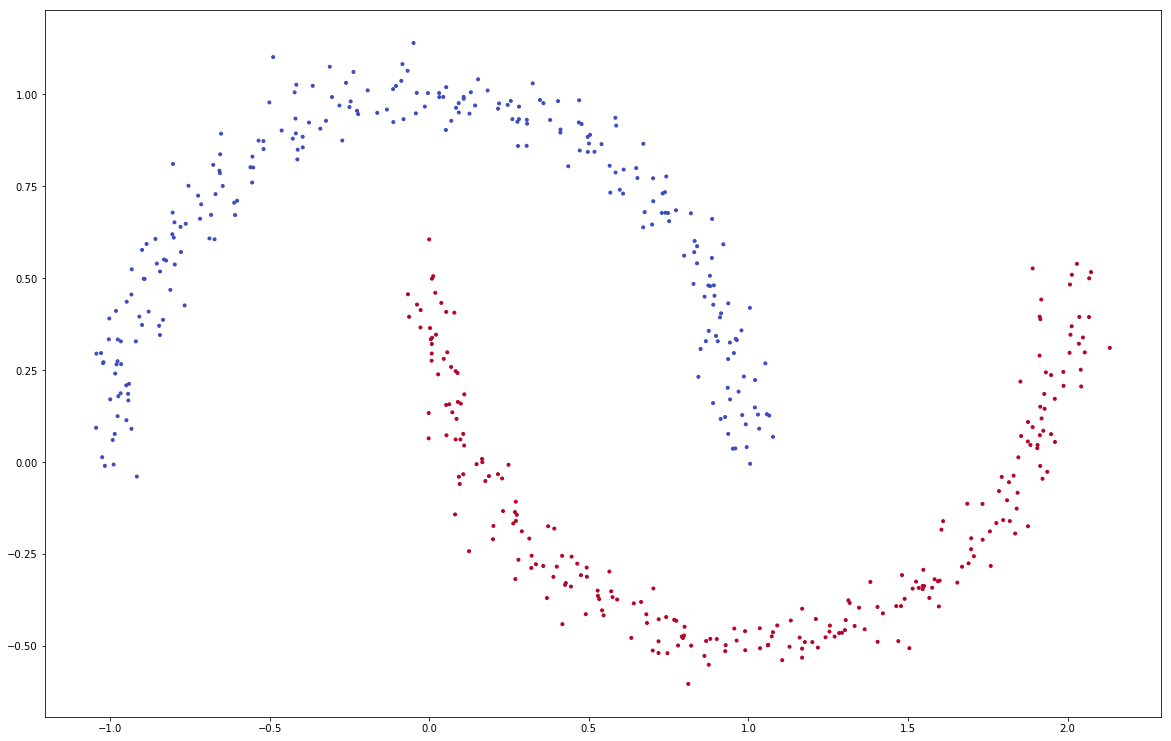

In [7]:
plt.scatter(X_2[:, 0], X_2[:, 1], c = y_2, marker = '.', alpha = 1, cmap=plt.cm.coolwarm)

In [35]:
X_3, y_3 = datasets.make_classification(n_samples=500, n_features=2, n_redundant=0, 
                                        n_classes=2, n_clusters_per_class=1, flip_y=0, class_sep=5,
                                        hypercube=False, random_state=30)

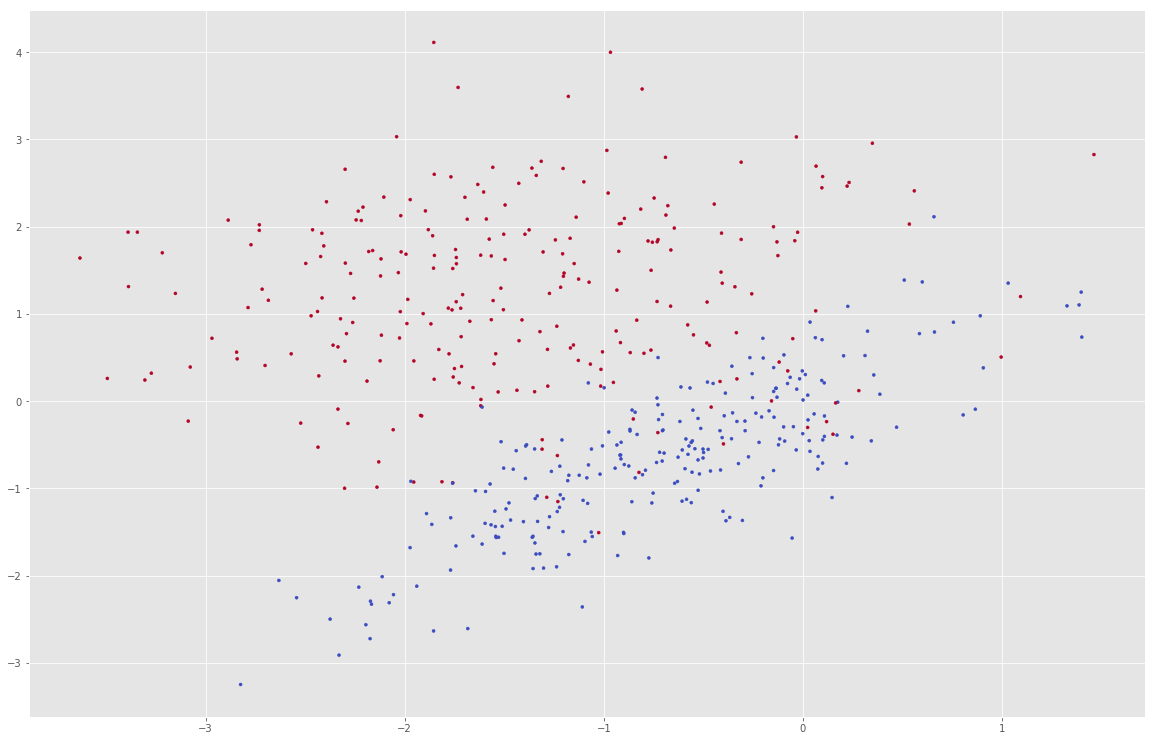

In [36]:
plt.scatter(X_3[:, 0], X_3[:, 1], c = y_3, marker = '.', alpha = 1, cmap=plt.cm.coolwarm)

Рассмотрим(https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

In [37]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

Построим линейное ядро

In [45]:
def lin_plot(X, y):
    models = (SVC(kernel='linear', C = 0.01),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 10),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
    models = (clf.fit(X, y) for clf in models)
    
    figure = plt.rcParams["figure.figsize"]
    figure[0] = 20
    figure[1] = 13
    plt.show()
    
    # title for the plots
    titles = ('lin_kernel, C = 0.01',
          'lin_kernel, C = 0.5',
          'lin_kernel, C = 1',
          'lin_kernel, C = 10', 
          'lin_kernel, C = 50',
          'lin_kernel, C = 100')

    fig, sub = plt.subplots(3, 2)
    plt.subplots_adjust(wspace=0.8, hspace=0.8)


    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.5)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='g')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

Построим полиномиальное ядро

In [52]:
def poly_plot(X, y):
    models = (SVC(kernel='poly', gamma = 0.001, degree = 2, C = 0.01),
          SVC(kernel = 'poly', gamma = 0.5, degree = 2, C = 0.01),
          SVC(kernel='poly', gamma = 0.001, degree = 3, C = 0.01),
          SVC(kernel = 'poly', gamma = 0.5, degree = 3, C = 0.01),
          SVC(kernel = 'poly', gamma = 0.001, degree = 2, C = 1),
          SVC(kernel = 'poly', gamma = 0.5, degree = 2, C = 1),
          SVC(kernel = 'poly', gamma = 0.001, degree = 3, C = 1),
          SVC(kernel = 'poly', gamma = 0.5, degree = 3, C = 1),
          SVC(kernel = 'poly', gamma = 0.001, degree = 2, C = 10),
          SVC(kernel = 'poly', gamma = 0.5, degree = 2, C = 10),
          SVC(kernel = 'poly', gamma = 0.001, degree = 3, C = 10),
          SVC(kernel = 'poly', gamma = 0.5, degree = 3, C = 10))
    models = (clf.fit(X, y) for clf in models)
    
    figure = plt.rcParams["figure.figsize"]
    figure[0] = 20
    figure[1] = 13
    plt.show()
    
    # title for the plots
    titles = ('poly kernel, gamma = 0.001, degree = 2, C = 0.01',
          'pol_kernel, gamma = 0.5, degree = 2, C = 0.01',
          'pol_kernel, gamma = 0.001, degree = 3, C = 0.01',
          'pol_kernel, gamma = 0.5, degree = 3, C = 0.01', 
          'pol_kernel, gamma = 0.001, degree = 2, C = 1',
          'pol_kernel, gamma = 0.5, degree = 2, C = 1',
          'pol_kernel, gamma = 0.001, degree = 3, C = 1',
          'pol_kernel, gamma = 0.5, degree = 3, C = 1',
          'pol_kernel, gamma = 0.001, degree = 2, C = 10',
          'pol_kernel, gamma = 0.5, degree = 2, C = 10',
          'pol_kernel, gamma = 0.001, degree = 3, C = 10',
          'pol_kernel, gamma = 0.5, degree = 3, C = 10')

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(3, 4)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)


    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.RdYlGn, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.RdYlGn, s=20, edgecolors='g')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        

Построим гауссовское ядро

In [58]:
def rbf_plot(X,y):
    models = (SVC(kernel='rbf', gamma = 0.001, C = 0.01),
             SVC(kernel='rbf', gamma = 0.001, C = 1),
             SVC(kernel='rbf', gamma = 0.001, C = 10),
             SVC(kernel='rbf', gamma = 0.1, C = 0.01),
             SVC(kernel='rbf', gamma = 0.1, C = 1),
             SVC(kernel='rbf', gamma = 0.1, C = 10),
             SVC(kernel='rbf', gamma = 1, C = 0.01),
             SVC(kernel='rbf', gamma = 1, C = 1),
             SVC(kernel='rbf', gamma = 1, C = 10)
             )
    models = (clf.fit(X, y) for clf in models)
    
    figure = plt.rcParams["figure.figsize"]
    figure[0] = 20
    figure[1] = 13
    plt.show()
    
    # title for the plots
    titles = ('rbf kernel, gamma = 0.001, C = 0.01',
          'rbf_kernel, gamma = 0.001, C = 1',
          'rbf_kernel, gamma = 0.001, C = 10', 
          'rbf_kernel, gamma = 0.1, C = 0.01',
          'rbf_kernel, gamma = 0.1, C = 1',
          'rbf_kernel, gamma = 0.1, C = 10',
          'rbf_kernel, gamma = 1, C = 0.01',
          'rbf_kernel, gamma = 1, C = 1',
          'rbf_kernel, gamma = 1, C = 10')

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(3, 3)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)


    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.5)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='g')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

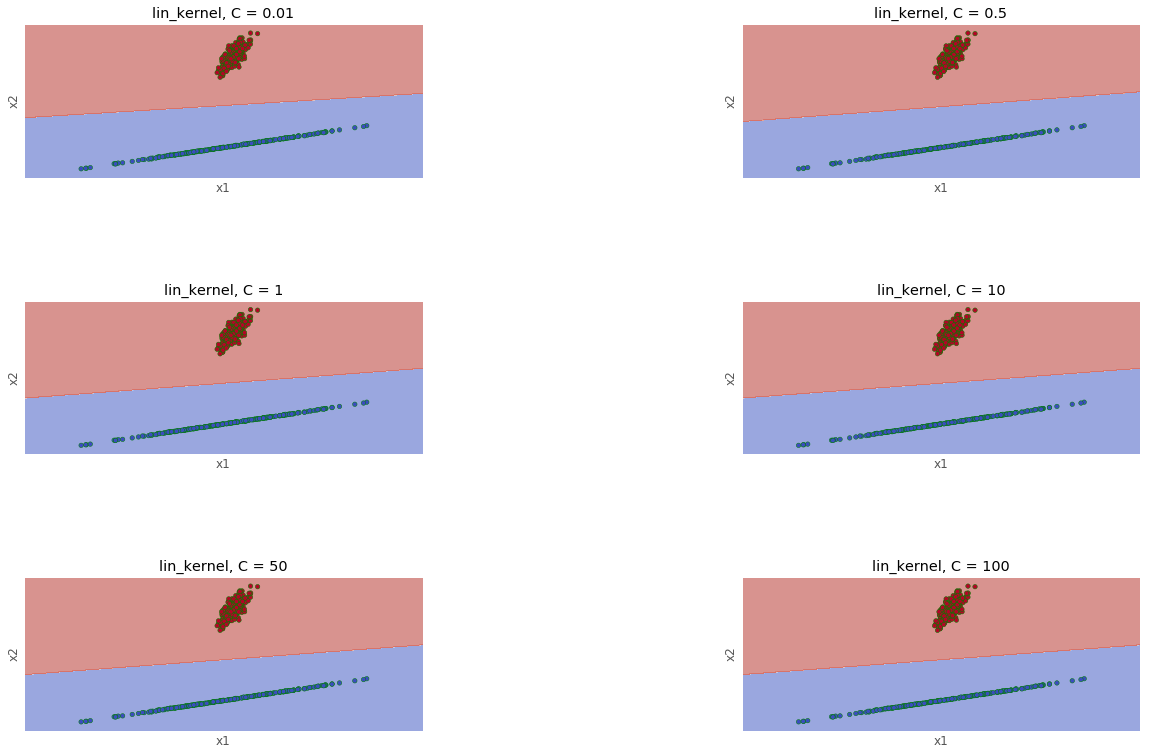

In [46]:
lin_plot(X_1, y_1)

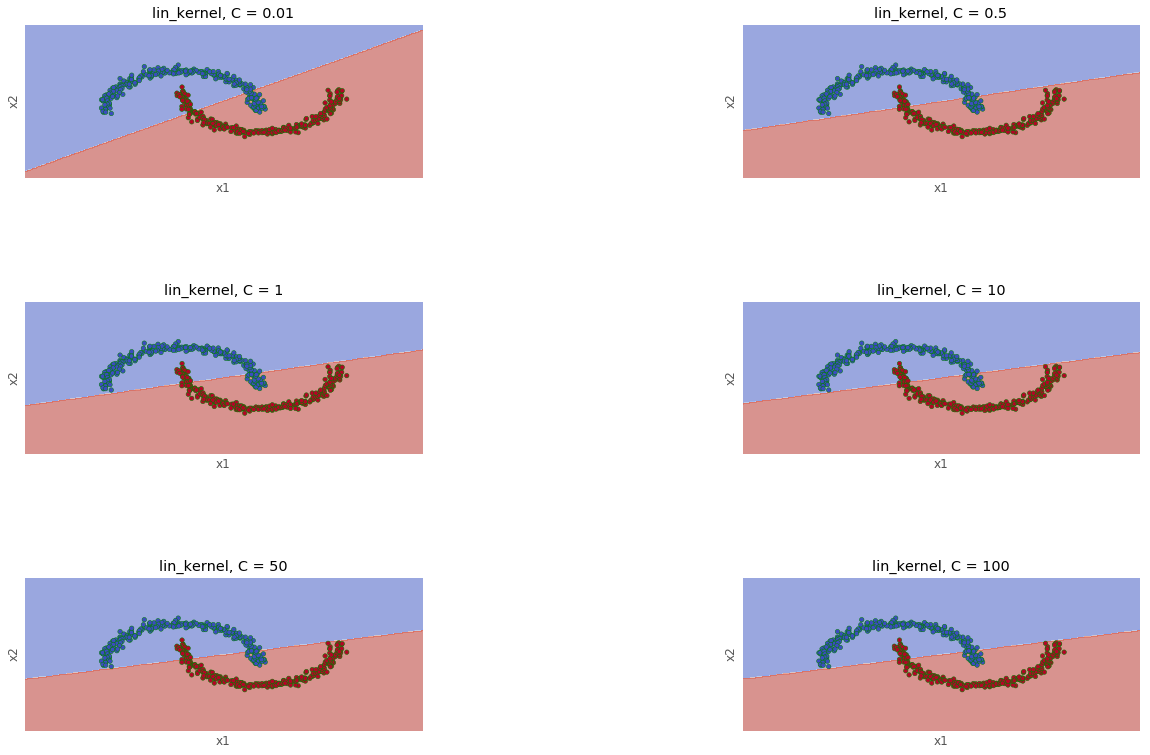

In [47]:
lin_plot(X_2, y_2)

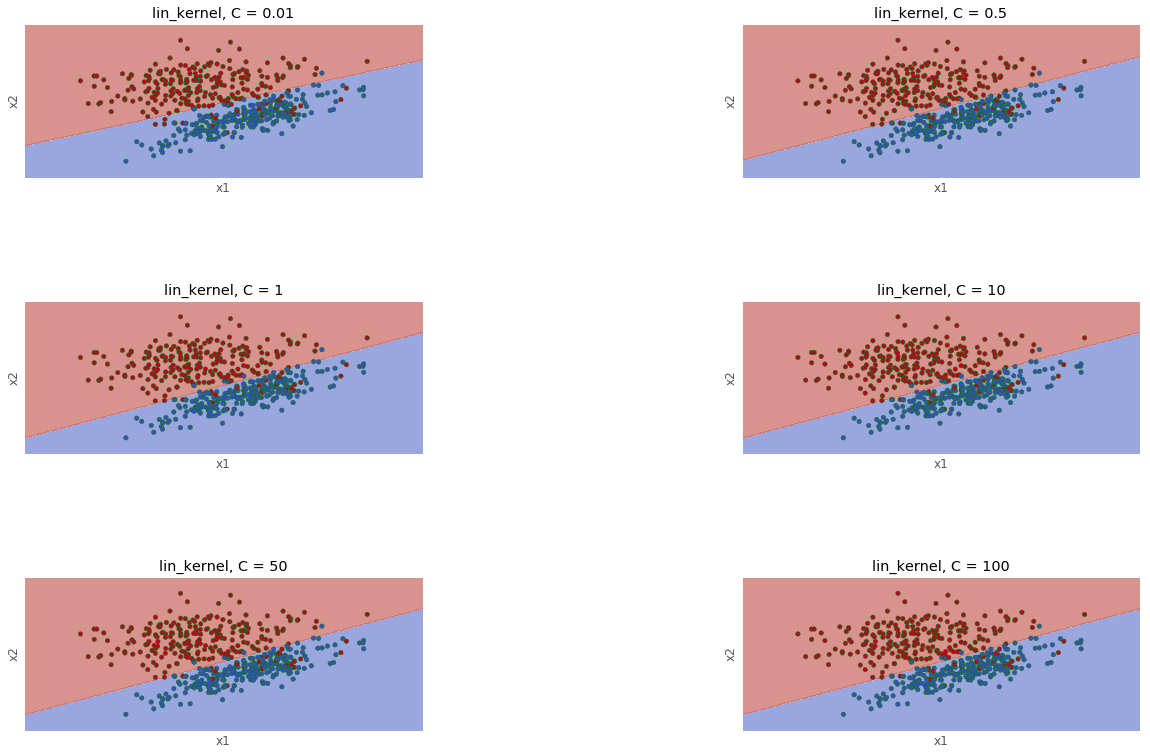

In [48]:
lin_plot(X_3, y_3)

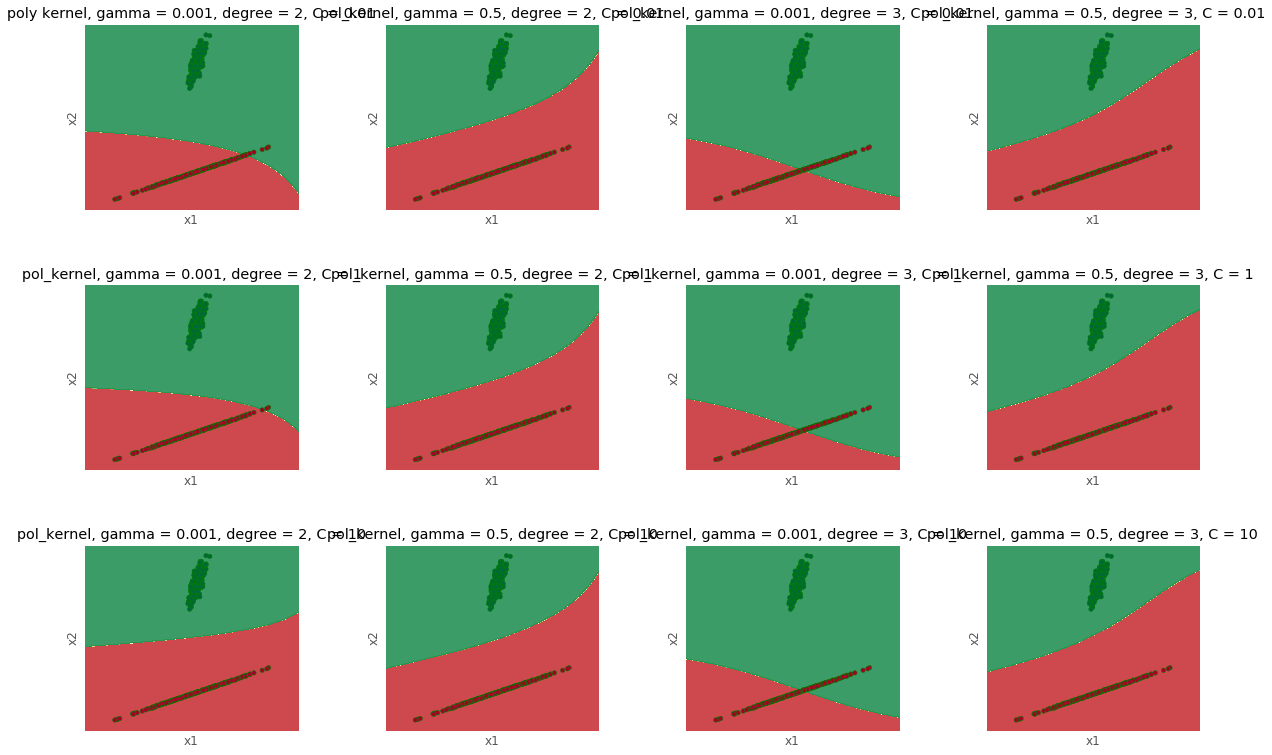

In [53]:
poly_plot(X_1, y_1)

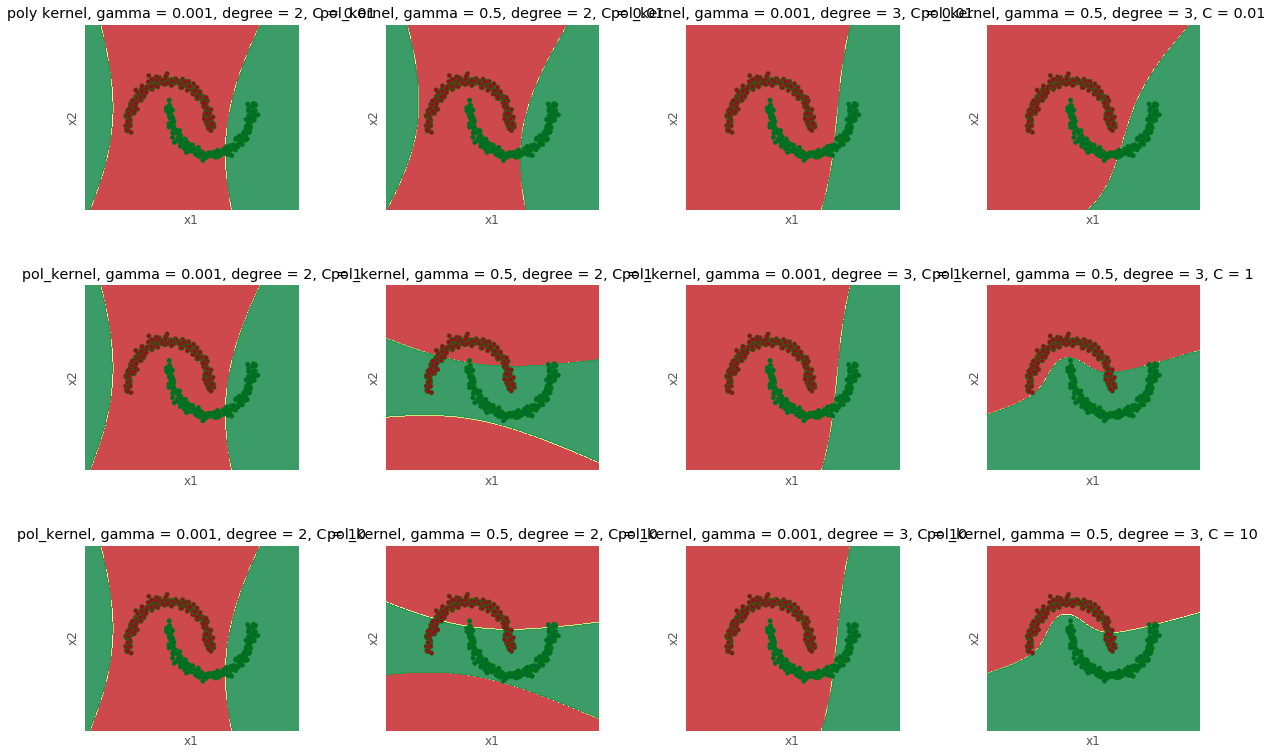

In [55]:
poly_plot(X_2, y_2)

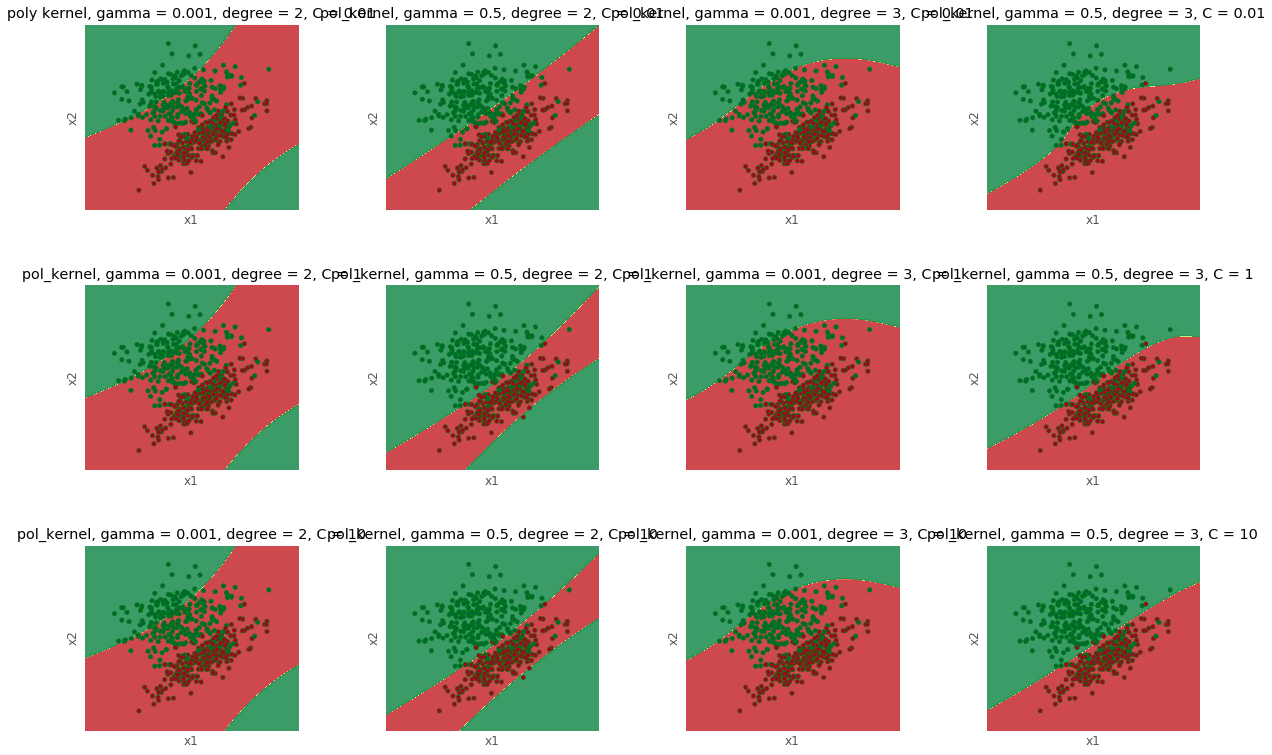

In [56]:
poly_plot(X_3, y_3)

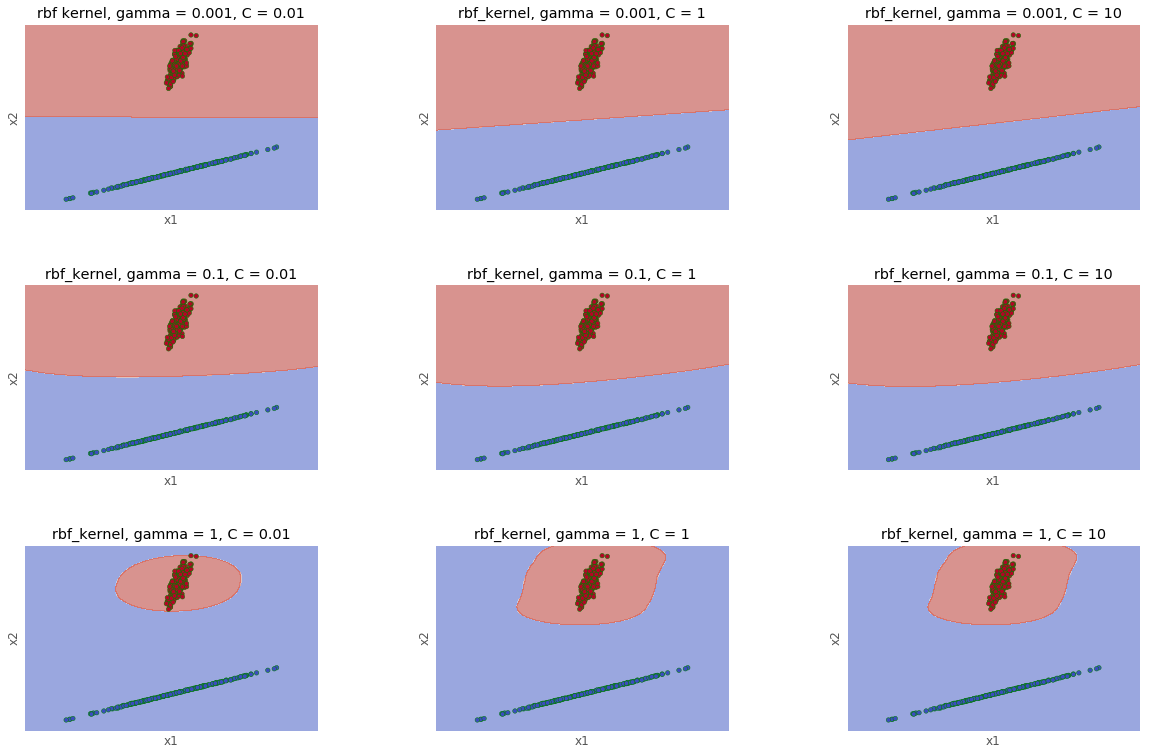

In [59]:
rbf_plot(X_1, y_1)

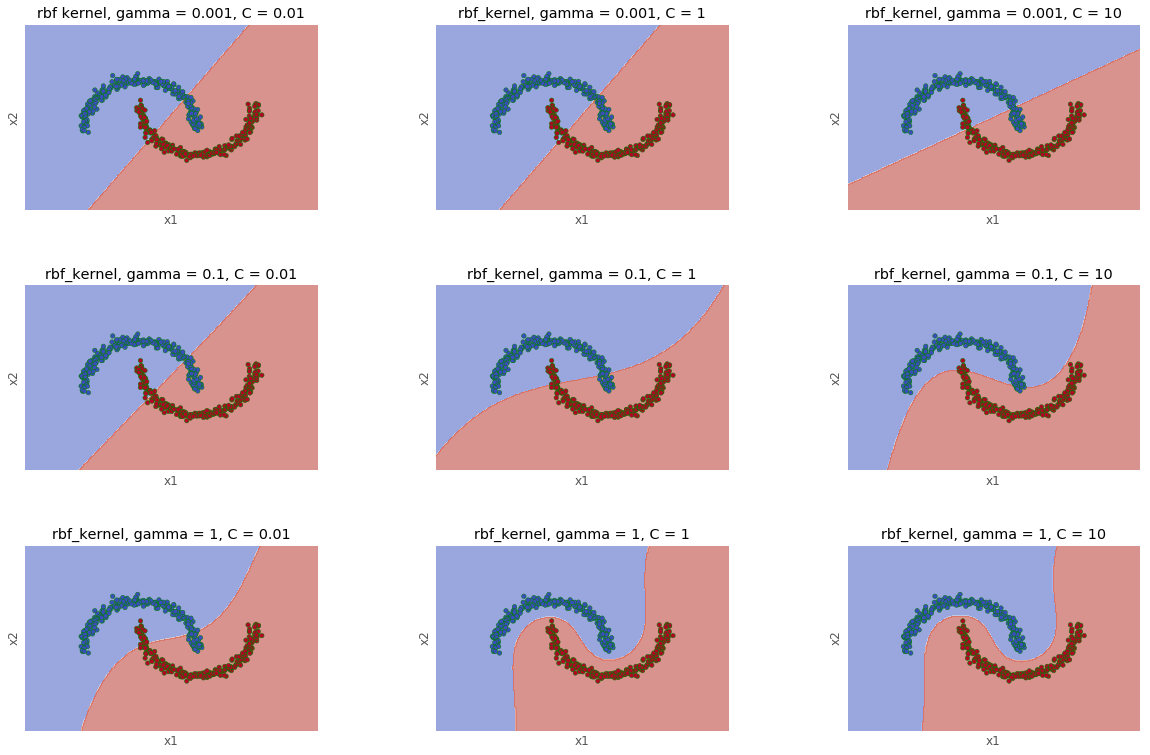

In [60]:
rbf_plot(X_2, y_2)

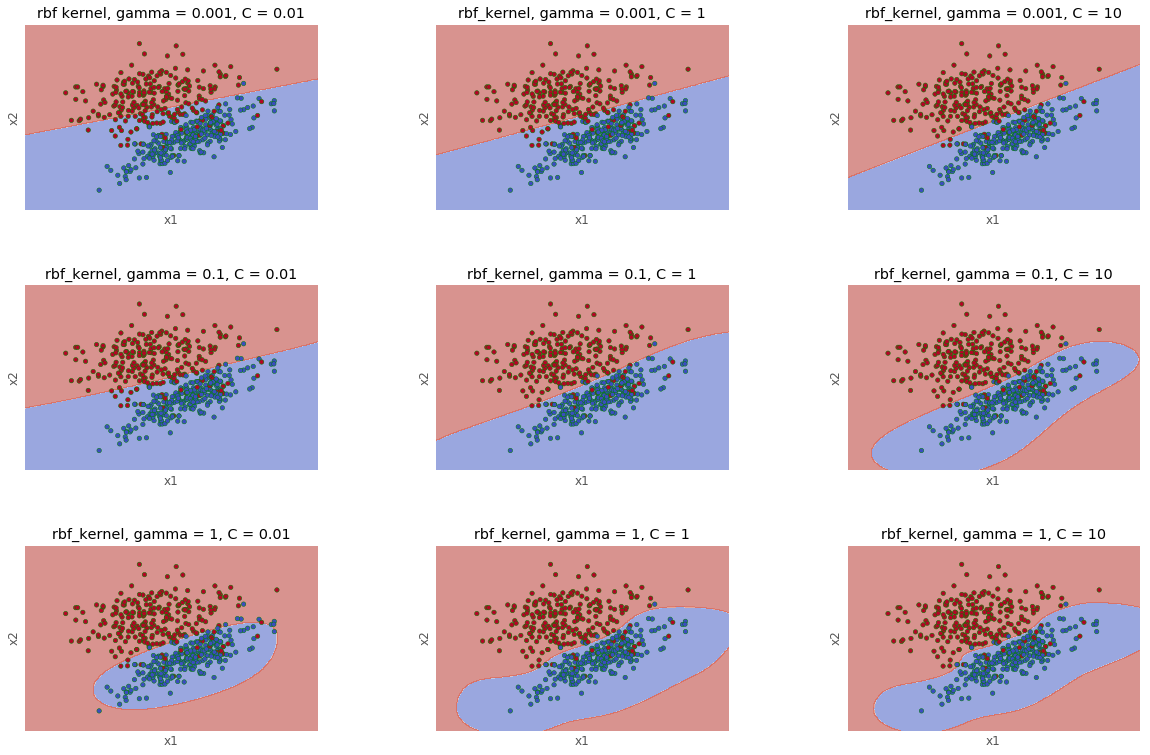

In [61]:
rbf_plot(X_3, y_3)

**3. (1 балл)** Ответьте на следующие вопросы:
 - SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 Уменьшение $С$ приводит к построению более гладкой гиперплоскости, но увеличивает число неправильно определенных объектов, также приводит к переобучению алгоритма. $d$ отвечает за пространство используемых признаков, рост параметра может приводить к переобучению. Большие $\gamma$ приводят к переобучению
 - SVM с гауссовским ядром 
 С ростом $\gamma$ переобучается, рост $С$ говорит о увеличении попыток классифицирования как можно больших объектов правильной меткой.

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [11]:
df = pd.read_csv('train.csv')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size = 0.5, random_state = 30)

In [81]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'degree':[2, 3], 'gamma':['auto', 0.01, 1]}
svc = SVC(C = 1, random_state = 30)
clf = GridSearchCV(svc, parameters, scoring = 'accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=30, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'degree': [2, 3], 'gamma': ['auto', 0.01, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [82]:
print('best score:', clf.best_score_)
print('best estimator:', clf.best_estimator_)

best score: 0.764266666667
best estimator: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=30, shrinking=True,
  tol=0.001, verbose=False)


**Ответ:** позволяет

## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [15]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

Посмотрим на нее:

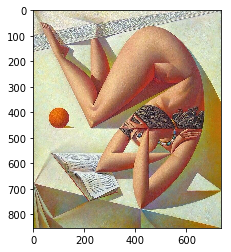

In [16]:
plt.imshow(img);

Для удобства оставим только один канал.

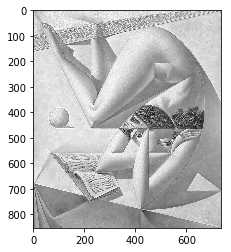

In [17]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

In [63]:
from numpy.linalg import svd

In [64]:
U, s, V = svd(img)
S = np.zeros((len(U), len(V)))
S[:len(V), :len(V)] = np.diag(s)

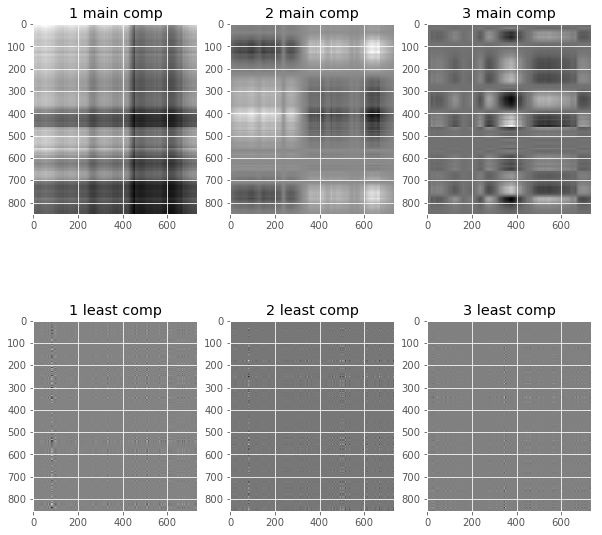

In [65]:
def PCA_comp(N):
    return U[:, N-1].reshape(-1, 1).dot(S[N-1, N-1]).dot(V[N-1, :].reshape(1, -1))

plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(2, 3, i), plt.title(str(i)+' main comp'),  plt.imshow(PCA_comp(i), cmap = 'gray')
    plt.subplot(2, 3, i+3), plt.title(str(i)+' least comp'), plt.imshow(PCA_comp((len(s)) - i), cmap = 'gray')

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


In [66]:
var_share = s/sum(s)
var_share_cum = []
for i in range(len(s)): var_share_cum.append( sum(var_share[:i]))

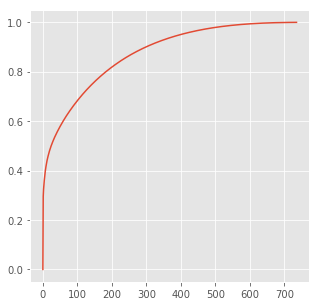

In [68]:
plt.figure(figsize=(5,5))
plt.style.use('ggplot')
plt.plot(var_share_cum)

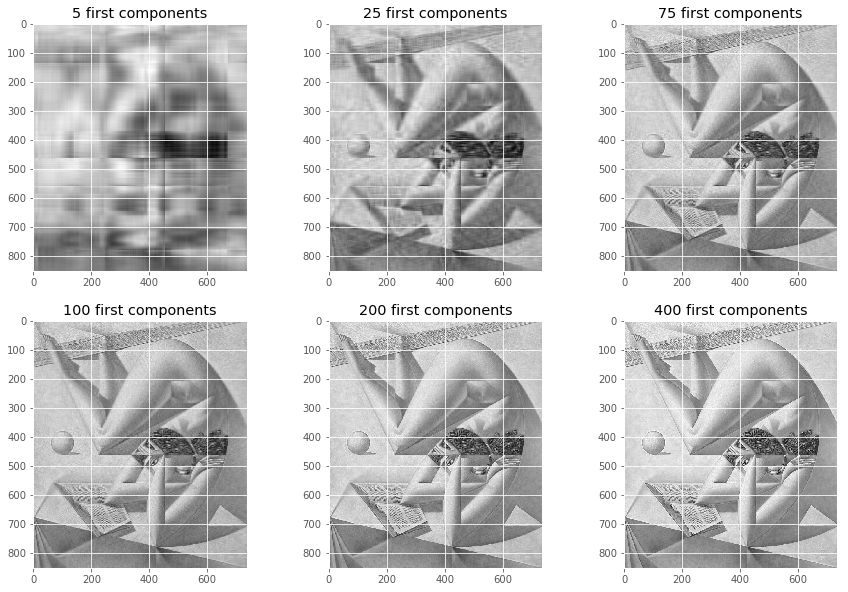

In [69]:
def PCA_main(N):
    return U[:, :N].dot(S[:N, :N]).dot(V[:N, :])

plt.figure(figsize=(15,10))
ncomp = [5, 25, 75, 100, 200, 400]
for i in range(1,7):
    n = ncomp[i-1]
    plt.subplot(2, 3, i), plt.title(str(n) + ' first comp'),  plt.imshow(PCA_main(n), cmap = 'gray')

Разница между 100, 200 и 400 компонентами практически незаметна

## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

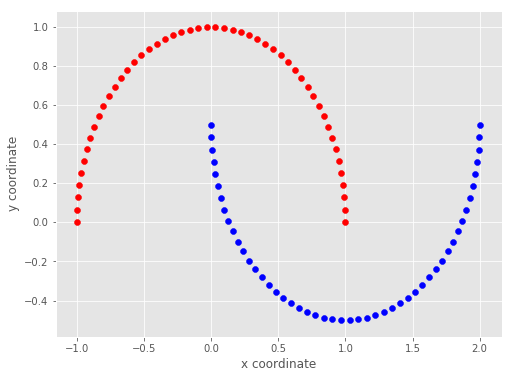

In [24]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


In [25]:
from sklearn.decomposition import PCA
pca1 = PCA(1)
pca1.fit(X)
pca2 = PCA(2)
pca2.fit(X)
print(pca1.explained_variance_ratio_ , pca2.explained_variance_ratio_)


[ 0.81968748] [ 0.81968748  0.18031252]


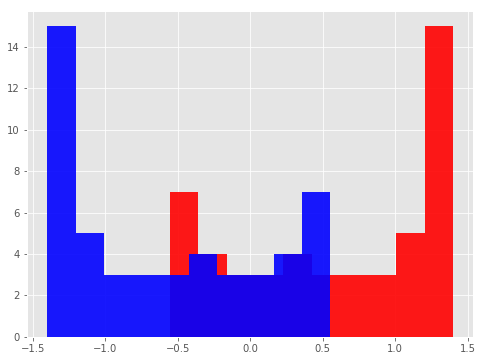

In [71]:
pc1 = pca1.transform(X)

plt.figure(figsize=(8,6))

plt.hist(pc1[y==0], color='red', alpha = 0.9)
plt.hist(pc1[y==1], color='blue', alpha = 0.9)

plt.show()

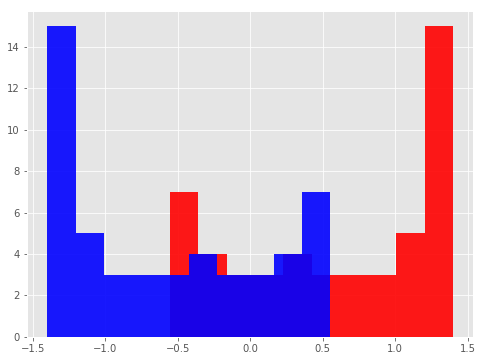

In [72]:
pc2 = pca2.transform(X)
plt.figure(figsize=(8,6))

plt.hist(pc2[y==0, 0], color='red', alpha = 0.9)
plt.hist(pc2[y==1, 0], color='blue', alpha = 0.9)

plt.show()

### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы Грамма для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний sq_dists

In [76]:
from scipy.spatial.distance import pdist 
from scipy.spatial.distance import squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [77]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K = np.exp(-gamma*mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

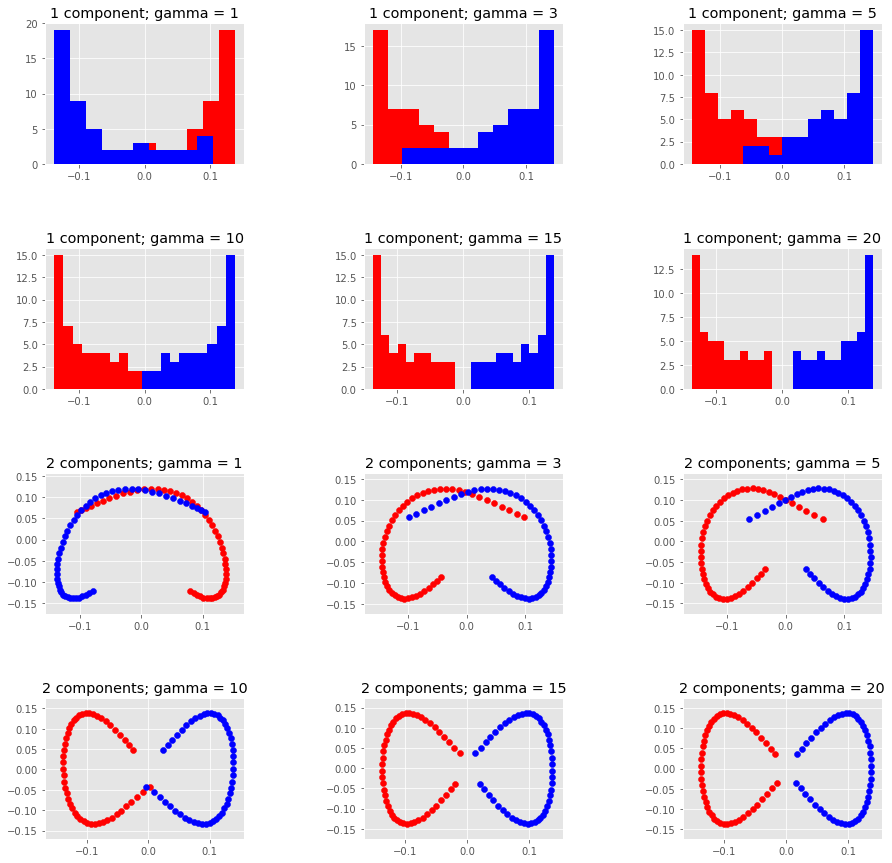

In [79]:
gamma_list = [1, 3, 5, 10, 15, 20]

plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.6, hspace=0.6)
for i in range(1,7):
    gamma = gamma_list[i-1]
    pc1 = stepwise_kpca(X, gamma = gamma, n_components=1)
    plt.subplot(4, 3, i)
    plt.hist(pc1[y==0], color='red')
    plt.hist(pc1[y==1], color='blue')
    plt.title('1 component; ' + 'gamma = ' + str(gamma))
    
    pc2 = stepwise_kpca(X, gamma = gamma, n_components=2)
    plt.subplot(4, 3, i+6)
    plt.scatter(pc2[y==0, 0], pc2[y==0, 1], color='red')
    plt.scatter(pc2[y==1, 0], pc2[y==1, 1], color='blue')
    plt.title('2 components; ' + 'gamma = ' + str(gamma))
plt.show()

Минимальная Гамма, при которой получается линейно разделить выборку:15

### Ваши мысли о задании:

### Здесь можете поделиться картинкой